<a href="https://colab.research.google.com/github/freddyjaoko/heatwave-prediction/blob/main/heatwave_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import missingno
import tensorflow as tf
import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer



##Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/heat-wave-data/data/ea.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322773 entries, 0 to 322772
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              322773 non-null  int64  
 1   country                 322773 non-null  object 
 2   native_name             322773 non-null  object 
 3   iso2                    322773 non-null  object 
 4   iso3                    322773 non-null  object 
 5   population              322773 non-null  float64
 6   area                    305534 non-null  float64
 7   capital                 322773 non-null  object 
 8   capital_lat             322773 non-null  float64
 9   capital_lng             322773 non-null  float64
 10  region                  322773 non-null  object 
 11  continent               322773 non-null  object 
 12  station_id              322773 non-null  int64  
 13  city_name               322773 non-null  object 
 14  state               

In [ ]:
grouped = df.groupby(['country'])


###EDA

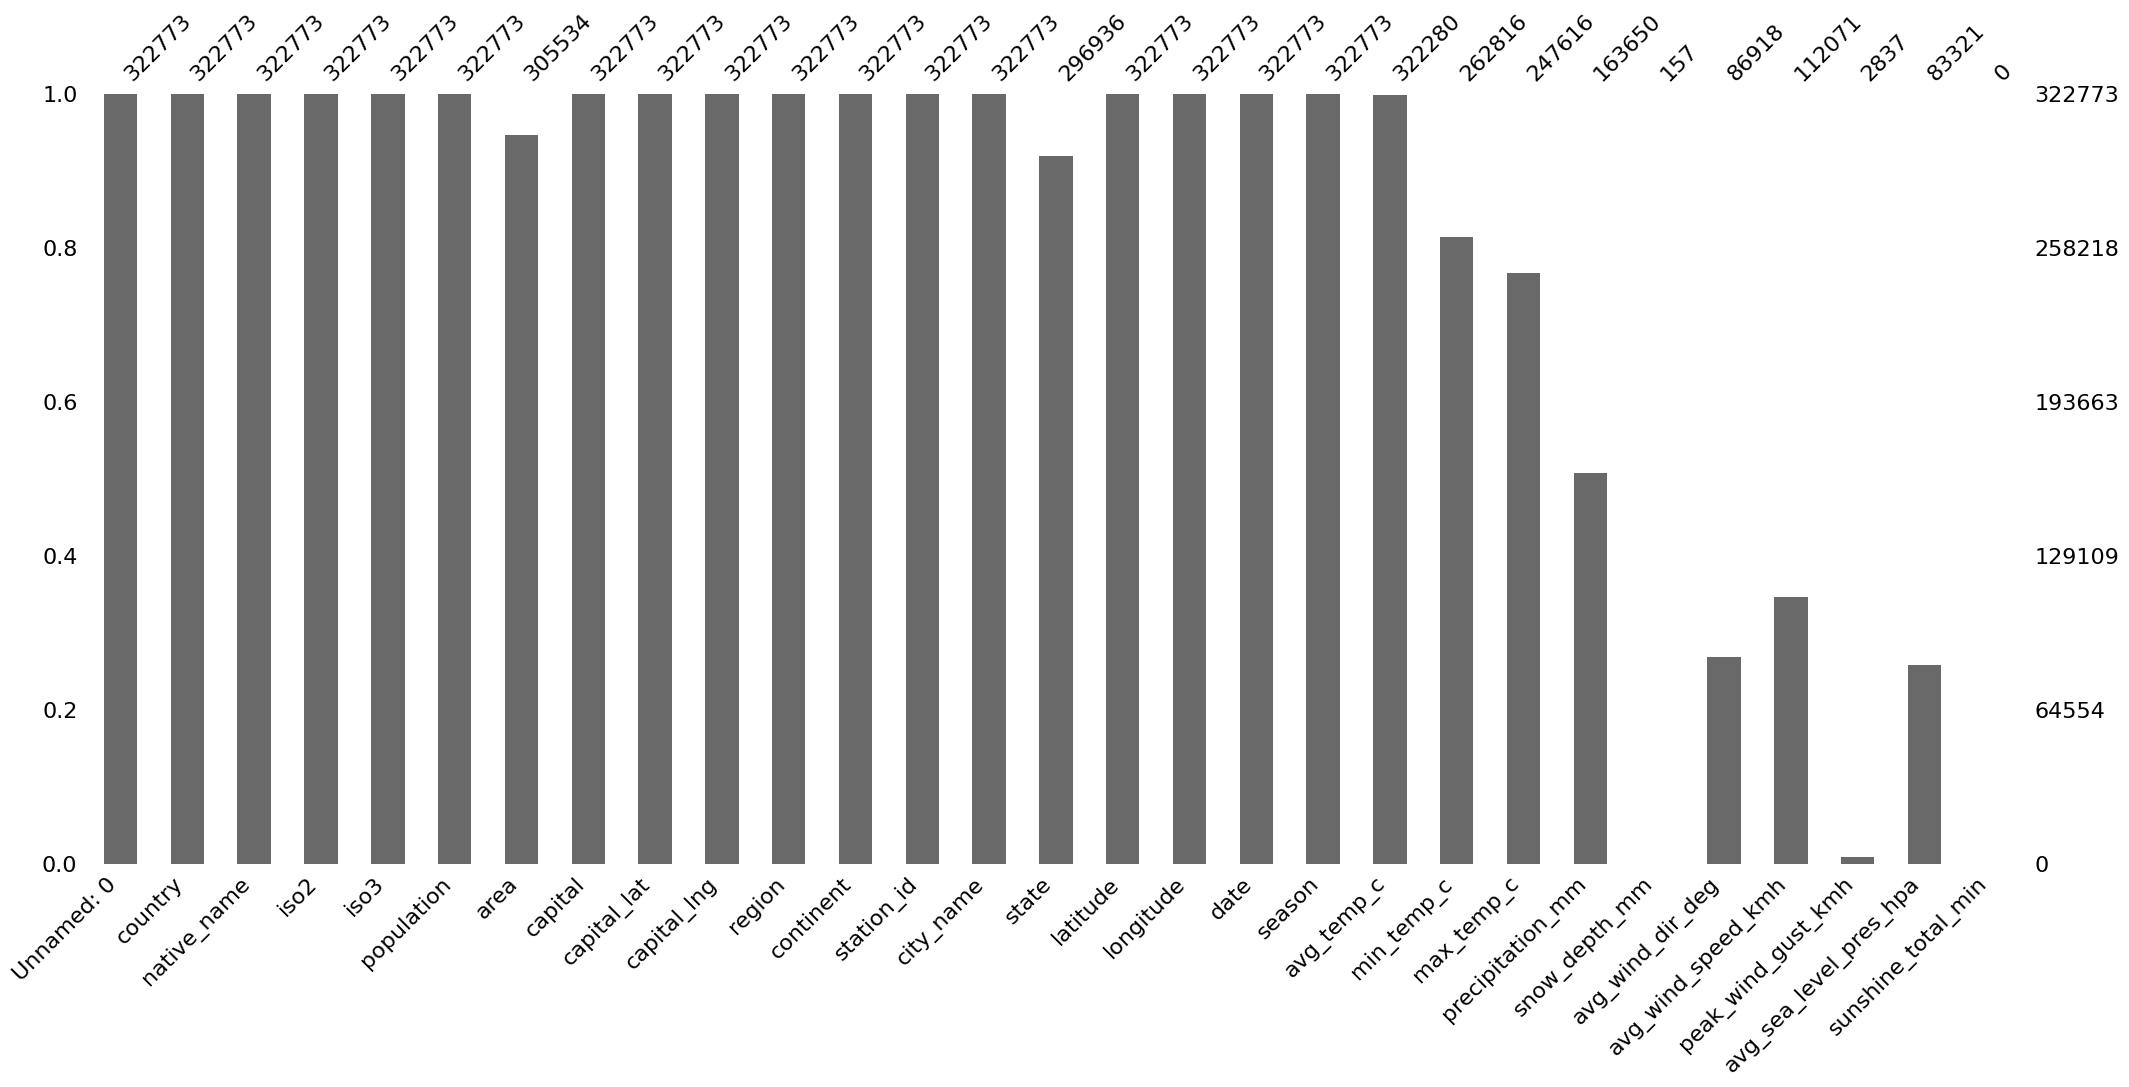

In [ ]:
missingno.bar(df)
plt.show()

Filtering the data so we only data from after the year 2010

In [ ]:
df = df[df['date']>='2020-01-01']

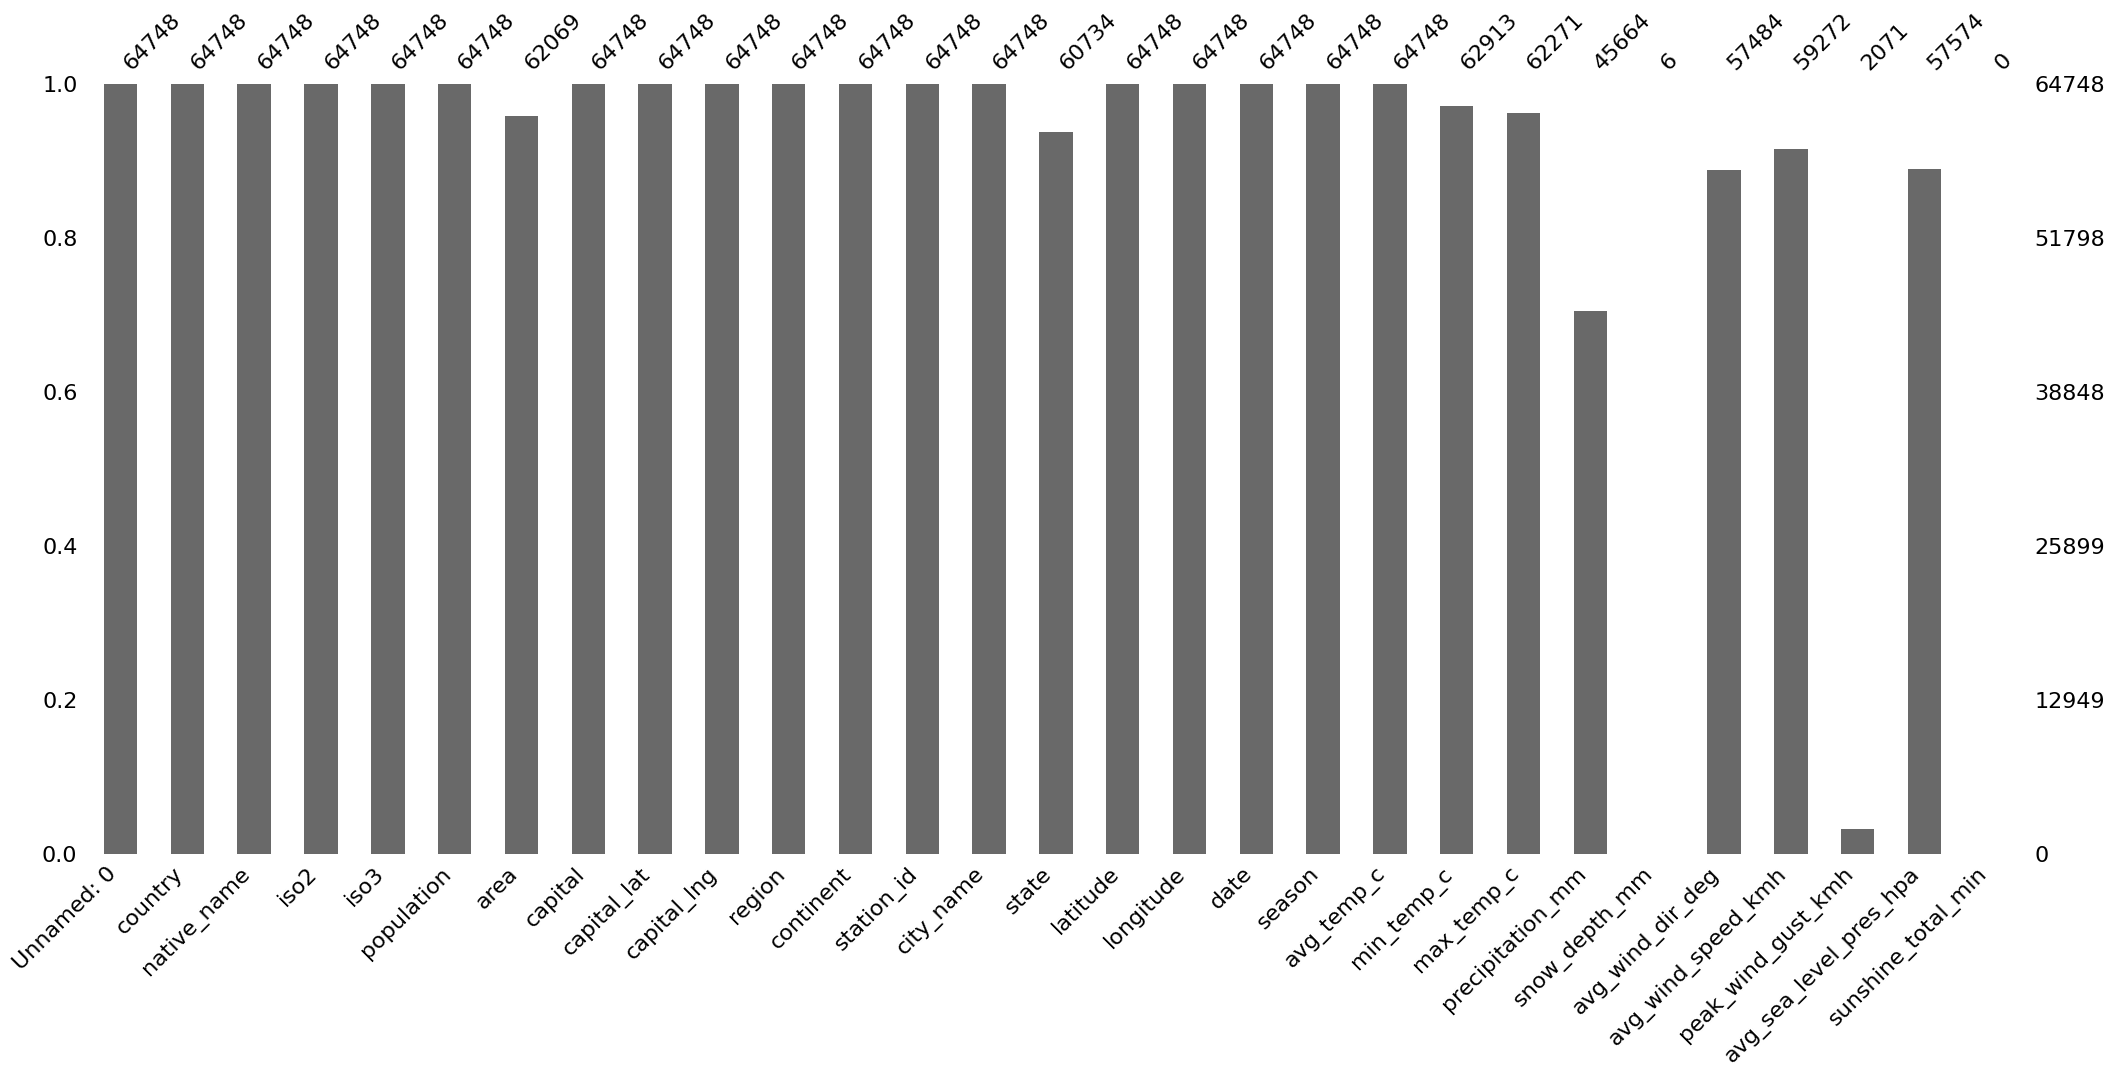

In [ ]:
missingno.bar(df)
plt.show()

In [ ]:
#test null values
percent_missing = df.isna().sum()* 100 / len(df)
missing_value = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value


,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000000
country,country,0.000000
native_name,native_name,0.000000
iso2,iso2,0.000000
iso3,iso3,0.000000
population,population,0.000000
area,area,4.137580
capital,capital,0.000000
capital_lat,capital_lat,0.000000
capital_lng,capital_lng,0.000000


Text(0.5, 0, 'columns')

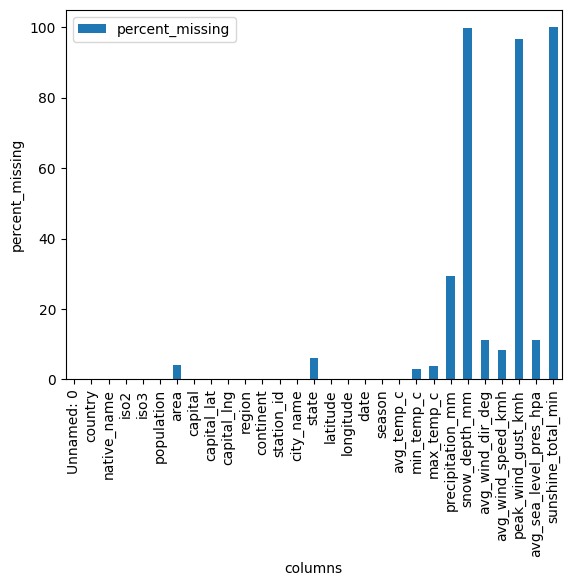

In [ ]:
missing_value.plot(kind='bar')
plt.ylabel('percent_missing')
plt.xlabel('columns')

In [ ]:
df = df[df['country'] =='Kenya']

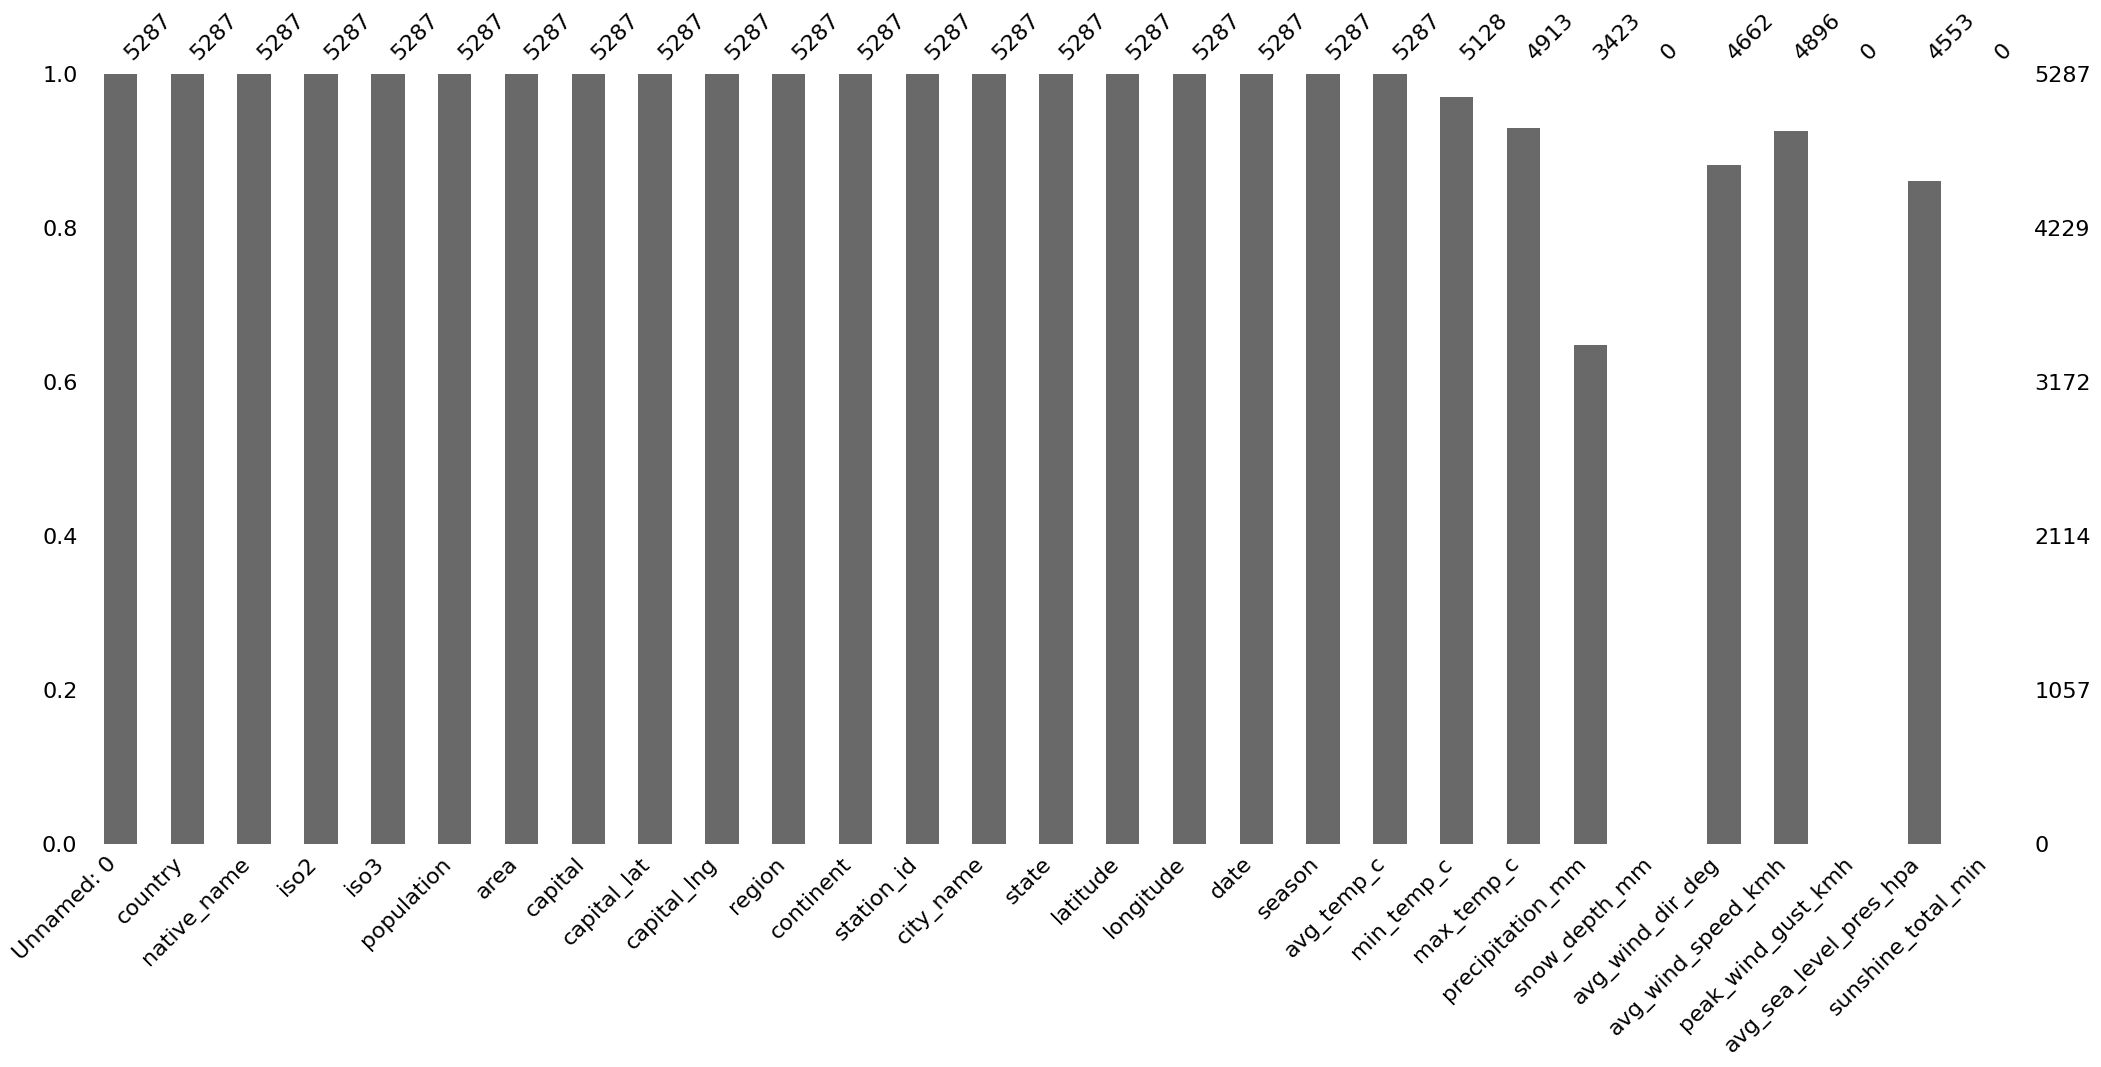

In [ ]:
missingno.bar(df)
plt.show()

In [ ]:
#dropping some irrelevant columns
df.drop(columns=['capital', 'capital_lat', 'capital_lng', 'iso2', 'iso3', 'population', 'native_name', 'continent', 'region','sunshine_total_min', 'Unnamed: 0', 'snow_depth_mm', 'peak_wind_gust_kmh', 'station_id' ], inplace=True, axis=1)

In [ ]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Extract year, month, and day components into separate columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

##Visualizing

Max Temperature

In [ ]:
fig = px.line(df, x='date', y='max_temp_c', color='city_name', title='MAX TEMP OVER TIME')

# Customize the layout (optional)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Max_Temp')

# Show the plot
fig.show()


*   From the visualization we can see there is a trend in the max temperature
*   This is a good case to use a deep learning model
*   List item







## precipitation

In [ ]:
fig = px.line(df, x='date', y='precipitation_mm', color='city_name', title='Time Series Plot')

# Customize the layout (optional)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Max_Temp')

# Show the plot
fig.show()

## Wind Speed

In [ ]:
df.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5287 entries, 44639 to 67740
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   country                 5287 non-null   object        
 1   area                    5287 non-null   float64       
 2   city_name               5287 non-null   object        
 3   state                   5287 non-null   object        
 4   latitude                5287 non-null   float64       
 5   longitude               5287 non-null   float64       
 6   date                    5287 non-null   datetime64[ns]
 7   season                  5287 non-null   object        
 8   avg_temp_c              5287 non-null   float64       
 9   min_temp_c              5128 non-null   float64       
 10  max_temp_c              4913 non-null   float64       
 11  precipitation_mm        3423 non-null   float64       
 12  avg_wind_dir_deg        4662 non-null   flo

In [ ]:
fig = px.line(df, x='date', y='avg_wind_speed_kmh', color='city_name', title='AVG WIND SPEED OVER TIME')

# Customize the layout (optional)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Max_Temp')

# Show the plot
fig.show()

## Sea Level Pressure

In [ ]:
fig = px.line(df, x='date', y='avg_sea_level_pres_hpa', color='city_name', title='Time Series Plot')

# Customize the layout (optional)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Max_Temp')

# Show the plot
fig.show()

# Making the date the index

In [ ]:
df.set_index('date', inplace=True)

Seperating the data into categorical and numerical data

In [ ]:
cat_df = df.select_dtypes(include=['object'])

In [ ]:
num_df = df.select_dtypes(include=['float', 'int'])

### Imputing missing values

In [ ]:
df.fillna(method='bfill', inplace=True)

In [ ]:
df.fillna(0, inplace=True)

### Feature engineering

In [ ]:
# Calculate the sine and cosine of values in the "month" and "day" columns
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming a maximum of 31 days in a month
df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)

In [ ]:
df.drop(columns=['month', 'day'], inplace=True , axis=1)

In [ ]:
numdf = df.select_dtypes(include=['float','int'])

In [ ]:
df.describe()

,area,latitude,longitude,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,year,sin_month,cos_month,sin_day,cos_day
count,5287.0,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5.287000e+03,5.287000e+03,5.287000e+03,5287.000000
mean,580367.0,-1.366144,37.053757,20.511519,16.005145,25.939739,3.973520,108.833554,12.242349,1015.292169,2021.379043,4.988760e-02,-6.490181e-02,4.464362e-03,-0.018786
std,0.0,1.655315,1.773551,4.051612,4.957289,3.527330,9.394504,59.019863,3.606490,42.136690,1.064012,7.069853e-01,7.026085e-01,7.139250e-01,0.700091
min,580367.0,-4.040026,34.730014,11.800000,4.000000,15.600000,0.000000,1.000000,3.800000,0.000000,2020.000000,-1.000000e+00,-1.000000e+00,-9.987165e-01,-0.994869
25%,580367.0,-4.040026,34.730014,17.500000,12.500000,23.600000,0.000000,61.000000,9.500000,1014.300000,2020.000000,-5.000000e-01,-8.660254e-01,-7.247928e-01,-0.758758
50%,580367.0,-0.416997,36.951004,19.200000,14.500000,25.000000,0.600000,102.000000,11.900000,1016.200000,2021.000000,1.224647e-16,-1.836970e-16,-2.449294e-16,-0.050649
75%,580367.0,0.290407,39.689918,23.600000,20.400000,28.400000,2.500000,153.000000,15.100000,1019.900000,2022.000000,8.660254e-01,5.000000e-01,7.247928e-01,0.688967
max,580367.0,0.290407,39.689918,30.400000,27.500000,36.000000,117.100000,354.000000,34.800000,1027.900000,2023.000000,1.000000e+00,1.000000e+00,9.987165e-01,1.000000


# Creating feature interactions

In [ ]:
df['min_plus_avg'] = df['min_temp_c'] + df['avg_temp_c']
df['min_minus_avg'] = df['min_temp_c'] - df['avg_temp_c']
df['min_x_avg'] = df['min_temp_c']*df['avg_temp_c']

df['year_month_cos'] = df['year'] * df['cos_month']
df['year_day_cos'] = df['year'] * df['cos_day']
df['day_month_cos'] = df['cos_day'] * df['cos_month']

df['year_month_sin'] = df['year'] * df['sin_month']
df['year_day_sin'] = df['year'] * df['sin_day']
df['day_month_sin'] = df['sin_day'] * df['sin_month']


df['avg_pres_x_avg_temp'] = df['avg_sea_level_pres_hpa'] * df['avg_temp_c']


df['long_lat'] = df['longitude'] * df['latitude']


df['prod_longlat_year'] = df['long_lat']*df['year']
df['diff_longlat_year'] = df['long_lat']-df['year']
df['sum_longlat_year'] = df['long_lat']+df['year']

df['area_mean'] = df['area'].mean()
df['long_mean'] = df['longitude'].mean()
df['lat_mean'] = df['latitude'].mean()
df['min_temp_mean'] = df['min_temp_c'].mean()
df['avg_temp_mean'] = df['avg_temp_c'].mean()

In [ ]:
num_df = df.select_dtypes(include=['float', 'int'])

# Adding statistical information to the data

In [ ]:
def add_stats(data, feats):

    before_ = data.shape[1]
    cols = feats
    data['f_min']   = data[cols].fillna(0).min(axis = 1)
    data['f_max']   = data[cols].fillna(0).max(axis = 1)
    data['f_mean']  = data[cols].fillna(0).mean(axis = 1)
    data['f_sd']    = data[cols].fillna(0).std(axis = 1)
    data['f_median']= data[cols].fillna(0).median(axis = 1)
    data['f_sum']   = data[cols].fillna(0).sum(axis = 1)
    data['f_skew']  = data[cols].fillna(0).skew(axis=1)

    after_ = data.shape[1]
    new_cols = data.iloc[:,before_:after_].columns.tolist()

    return data, new_cols


In [ ]:
data, stat_cols = add_stats(df, [col for col in num_df])

In [ ]:
#data = pd.concat([cat_df, data], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5287 entries, 2020-01-01 to 2023-09-04
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 5287 non-null   object 
 1   area                    5287 non-null   float64
 2   city_name               5287 non-null   object 
 3   state                   5287 non-null   object 
 4   latitude                5287 non-null   float64
 5   longitude               5287 non-null   float64
 6   season                  5287 non-null   object 
 7   avg_temp_c              5287 non-null   float64
 8   min_temp_c              5287 non-null   float64
 9   max_temp_c              5287 non-null   float64
 10  precipitation_mm        5287 non-null   float64
 11  avg_wind_dir_deg        5287 non-null   float64
 12  avg_wind_speed_kmh      5287 non-null   float64
 13  avg_sea_level_pres_hpa  5287 non-null   float64
 14  year                  

In [ ]:
data.head()

,country,area,city_name,state,latitude,longitude,season,avg_temp_c,min_temp_c,max_temp_c,...,lat_mean,min_temp_mean,avg_temp_mean,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.1,10.9,23.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35509.987090,138336.641670,21.755759,1.207340e+06,3.918346
2020-01-02,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.4,9.9,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35525.721110,138333.665463,22.255759,1.207875e+06,3.918250
2020-01-03,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,18.2,14.0,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35557.299712,138328.576486,22.255759,1.208948e+06,3.917976
2020-01-04,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.8,12.2,23.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35545.276624,138330.106525,21.755759,1.208539e+06,3.918118
2020-01-05,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,18.8,14.0,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35574.635486,138326.530895,22.255759,1.209538e+06,3.917755


In [ ]:
data

,country,area,city_name,state,latitude,longitude,season,avg_temp_c,min_temp_c,max_temp_c,...,lat_mean,min_temp_mean,avg_temp_mean,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.1,10.9,23.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35509.987090,138336.641670,21.755759,1.207340e+06,3.918346
2020-01-02,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.4,9.9,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35525.721110,138333.665463,22.255759,1.207875e+06,3.918250
2020-01-03,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,18.2,14.0,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35557.299712,138328.576486,22.255759,1.208948e+06,3.917976
2020-01-04,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,17.8,12.2,23.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35545.276624,138330.106525,21.755759,1.208539e+06,3.918118
2020-01-05,Kenya,580367.0,Kakamega,Western,0.290407,34.730014,Winter,18.8,14.0,24.0,...,-1.366144,16.005145,20.511519,-2009.914149,580367.0,35574.635486,138326.530895,22.255759,1.209538e+06,3.917755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,Kenya,580367.0,Nyeri,Central,-0.416997,36.951004,Winter,19.2,15.4,24.3,...,-1.366144,16.005145,20.511519,-31171.309138,580367.0,33277.189658,138934.615679,0.500000,1.131424e+06,3.914904
2023-09-01,Kenya,580367.0,Nyeri,Central,-0.416997,36.951004,Spring,19.5,15.1,25.0,...,-1.366144,16.005145,20.511519,-31171.309138,580367.0,33309.213214,138926.708546,5.989765,1.132513e+06,3.914881
2023-09-02,Kenya,580367.0,Nyeri,Central,-0.416997,36.951004,Spring,19.7,14.9,25.7,...,-1.366144,16.005145,20.511519,-31171.309138,580367.0,33316.970185,138924.791990,6.159479,1.132777e+06,3.914875


###TARGET ENCODING

In [ ]:
target = df['max_temp_c']

In [ ]:
from category_encoders import TargetEncoder

# List of categorical columns to be target encoded
categorical_columns = ['state', 'city_name']

# Create a TargetEncoder instance
encoder = TargetEncoder()

# Initialize an empty DataFrame to store the encoded columns
encoded_data = pd.DataFrame()

# Target encode each categorical column and add it to the encoded_data DataFrame
for col in categorical_columns:
    encoded_col = encoder.fit_transform(data[col], target)
    encoded_data[col + '_encoded'] = encoded_col


In [ ]:
data.drop(columns=['state', 'city_name', 'country',], inplace=True, axis=1)

In [ ]:
data = pd.concat([encoded_data, data], axis=1)

Using One-Hot encoding on the country and season column

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5287 entries, 2020-01-01 to 2023-09-04
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state_encoded           5287 non-null   float64
 1   city_name_encoded       5287 non-null   float64
 2   area                    5287 non-null   float64
 3   latitude                5287 non-null   float64
 4   longitude               5287 non-null   float64
 5   season                  5287 non-null   object 
 6   avg_temp_c              5287 non-null   float64
 7   min_temp_c              5287 non-null   float64
 8   max_temp_c              5287 non-null   float64
 9   precipitation_mm        5287 non-null   float64
 10  avg_wind_dir_deg        5287 non-null   float64
 11  avg_wind_speed_kmh      5287 non-null   float64
 12  avg_sea_level_pres_hpa  5287 non-null   float64
 13  year                    5287 non-null   int64  
 14  sin_month             

In [ ]:
catdf = data.select_dtypes(include=['object'])

One hot encoding the season column

In [ ]:
one_hot_encoded = pd.get_dummies(catdf, columns=['season'])

Joining the columns

In [ ]:
data = pd.concat([data, one_hot_encoded], axis=1)

In [ ]:
data.drop(columns=['season'], inplace=True, axis= 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5287 entries, 2020-01-01 to 2023-09-04
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state_encoded           5287 non-null   float64
 1   city_name_encoded       5287 non-null   float64
 2   area                    5287 non-null   float64
 3   latitude                5287 non-null   float64
 4   longitude               5287 non-null   float64
 5   avg_temp_c              5287 non-null   float64
 6   min_temp_c              5287 non-null   float64
 7   max_temp_c              5287 non-null   float64
 8   precipitation_mm        5287 non-null   float64
 9   avg_wind_dir_deg        5287 non-null   float64
 10  avg_wind_speed_kmh      5287 non-null   float64
 11  avg_sea_level_pres_hpa  5287 non-null   float64
 12  year                    5287 non-null   int64  
 13  sin_month               5287 non-null   float64
 14  cos_month             

In [ ]:
# Calculate the correlation with 'max_temp_c', sort values, and filter columns with correlation < 0
data.corr()['max_temp_c'].sort_values()[data.corr()['max_temp_c'].sort_values() < 0]

f_skew                   -0.770323
f_min                    -0.736307
diff_longlat_year        -0.733658
long_lat                 -0.733099
prod_longlat_year        -0.733099
sum_longlat_year         -0.732347
latitude                 -0.725608
f_sum                    -0.718777
f_mean                   -0.718777
season_Winter            -0.199416
precipitation_mm         -0.082578
avg_sea_level_pres_hpa   -0.062944
sin_day                  -0.024429
year_day_sin             -0.024427
year_day_cos             -0.017800
cos_day                  -0.017783
Name: max_temp_c, dtype: float64

In [ ]:
# Calculate the correlation with 'max_temp_c', sort values, and filter columns with correlation < 0
selected_columns = data.corr()['max_temp_c'].sort_values()[data.corr()['max_temp_c'].sort_values() < 0].index

# Add the target column 'max_temp_c' to the selected columns
selected_columns = list(selected_columns) + ['max_temp_c', 'state_encoded', 'city_name_encoded', 'season_Autumn', 'season_Summer']

# Keep only the selected columns in the DataFrame
data = data[selected_columns]

# Now, 'data' contains only the columns with a negative correlation to 'max_temp_c' and the target column 'max_temp_c'


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5287 entries, 2020-01-01 to 2023-09-04
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   f_skew                  5287 non-null   float64
 1   f_min                   5287 non-null   float64
 2   diff_longlat_year       5287 non-null   float64
 3   long_lat                5287 non-null   float64
 4   prod_longlat_year       5287 non-null   float64
 5   sum_longlat_year        5287 non-null   float64
 6   latitude                5287 non-null   float64
 7   f_sum                   5287 non-null   float64
 8   f_mean                  5287 non-null   float64
 9   season_Winter           5287 non-null   uint8  
 10  precipitation_mm        5287 non-null   float64
 11  avg_sea_level_pres_hpa  5287 non-null   float64
 12  sin_day                 5287 non-null   float64
 13  year_day_sin            5287 non-null   float64
 14  year_day_cos          

## Scaling

In [ ]:
# Separate the target column from the features
target = data[['max_temp_c']]
features = data.drop(columns=['max_temp_c'], axis=1)

# Create StandardScaler instances for features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Standard scale the feature values
scaled_features = feature_scaler.fit_transform(features)

# Standard scale the target values
scaled_target = target_scaler.fit_transform(target)

# Create DataFrames for the scaled features and target
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, columns=target.columns)

# Concatenate the scaled features and the scaled target
scaled_df = pd.concat([scaled_features_df, scaled_target_df], axis=1)

In [ ]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   f_skew                  5287 non-null   float64
 1   f_min                   5287 non-null   float64
 2   diff_longlat_year       5287 non-null   float64
 3   long_lat                5287 non-null   float64
 4   prod_longlat_year       5287 non-null   float64
 5   sum_longlat_year        5287 non-null   float64
 6   latitude                5287 non-null   float64
 7   f_sum                   5287 non-null   float64
 8   f_mean                  5287 non-null   float64
 9   season_Winter           5287 non-null   float64
 10  precipitation_mm        5287 non-null   float64
 11  avg_sea_level_pres_hpa  5287 non-null   float64
 12  sin_day                 5287 non-null   float64
 13  year_day_sin            5287 non-null   float64
 14  year_day_cos            5287 non-null   

## Constructing the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer

# Creating a window for the input

*   A window is basically the input period
*   I'll input the data in periods of two weeks



In [ ]:
def df_to_X_y(df, window_size=14):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][20]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X, y = df_to_X_y(scaled_df)
X.shape, y.shape

((5273, 14, 21), (5273,))

In [ ]:
X

array([[[ 0.65155946,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.83349653],
        [ 0.65136414,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.54996914],
        [ 0.65080302,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.54996914],
        ...,
        [ 0.6524038 ,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -1.6840787 ],
        [ 0.65191913,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -1.40055131],
        [ 0.65077576,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.83349653]],

       [[ 0.65136414,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.54996914],
        [ 0.65080302,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.54996914],
        [ 0.65109465,  0.87671609,  0.98935903, ..., -0.5916943 ,
         -0.57596704, -0.83349653],
        ...,
        [ 0.65191913,  0.87671609,  0.98935903, ..., -

In [ ]:
y

array([-0.26644174, -0.54996914, -0.26644174, ..., -0.06797257,
        0.10214387,  0.04543839])

Train test and validation split

In [ ]:
X_train, y_train = X[:4500], y[:4500]
X_val, y_val = X[4500:5259], y[4500:5259]
X_test, y_test = X[5259:], y[5259:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4500, 14, 21), (4500,), (759, 14, 21), (759,), (14, 14, 21), (14,))

## Creating sequences for the model

###Creating the LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, MaxPooling1D, RepeatVector, InputLayer, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [ ]:
print("Num TPUs Available: ", len(tf.config.experimental.list_physical_devices('TPU')))


Num TPUs Available:  0


Using K-folds cross validation

In [ ]:
# Define the number of folds (k)
k = 3

# Initialize a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store MSE and R-squared scores
mse_scores = []
r2_scores = []

In [ ]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = Sequential()
    model.add(InputLayer((14, 21)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(365 ,'relu'))
    model.add(Dense(1, 'linear'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mean_squared_error')
    cp = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/models/lstm', save_best_only=True)


    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Implement learning rate scheduling
    def lr_scheduler(epoch):
        return 0.0001 * np.exp(-epoch / 10)

    learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

    # Train the model with early stopping and learning rate scheduling
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=3, batch_size=32, verbose=1, callbacks=[early_stopping, learning_rate_scheduler, cp])

    # Evaluate the model on the validation fold
    y_val_pred = model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

Epoch 1/3
94/94 [==============================] - 13s 75ms/step - loss: 0.6412 - val_loss: 0.3052 - lr: 1.0000e-04
Epoch 2/3
94/94 [==============================] - 8s 89ms/step - loss: 0.2364 - val_loss: 0.2283 - lr: 9.0484e-05
Epoch 3/3
47/47 [==============================] - 0s 4ms/step
Epoch 1/3
94/94 [==============================] - 7s 51ms/step - loss: 0.4953 - val_loss: 0.2884 - lr: 1.0000e-04
Epoch 2/3
94/94 [==============================] - 3s 31ms/step - loss: 0.2479 - val_loss: 0.2204 - lr: 9.0484e-05
Epoch 3/3
47/47 [==============================] - 0s 3ms/step
Epoch 1/3
94/94 [==============================] - 5s 33ms/step - loss: 0.4506 - val_loss: 0.2328 - lr: 1.0000e-04
Epoch 2/3
94/94 [==============================] - 4s 40ms/step - loss: 0.2193 - val_loss: 0.1757 - lr: 9.0484e-05
Epoch 3/3
47/47 [==============================] - 0s 4ms/step


In [ ]:
# Print the MSE and R-squared scores for each fold
for i, (mse, r2) in enumerate(zip(mse_scores, r2_scores)):
    print(f"Fold {i+1}: MSE = {mse}, R-squared = {r2}")


Fold 1: MSE = 0.18205786420936954, R-squared = 0.8340996756753295
Fold 2: MSE = 0.18396312458546143, R-squared = 0.8335314076143279
Fold 3: MSE = 0.15124708679935384, R-squared = 0.8533800720499343


In [ ]:
variance = np.var(y_val_fold)

In [ ]:
pmse = (mse / variance) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Percentage Mean Squared Error (PMSE): {pmse:.2f}%')

Mean Squared Error (MSE): 0.15124708679935384
Percentage Mean Squared Error (PMSE): 14.66%


In [ ]:
# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)
print("Average Mean Squared Error:", average_mse)

Average Mean Squared Error: 0.17242269186472825


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/models/lstm')

## Predicting the test data

In [ ]:
y_pred = model1.predict(X_test)

1/1 [==============================] - 0s 202ms/step


In [ ]:
y_true = y_test

In [ ]:
y_true.shape , y_pred.shape

((14,), (14, 1))

In [ ]:
y_pred = y_pred.flatten()
y_true = y_true.flatten()

In [ ]:
test_results = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_true})

# Inverse transform the 'Actuals' and 'Train Predictions' columns
test_results['Actuals'] = target_scaler.inverse_transform(test_results[['Actuals']])
test_results['Test Predictions'] = target_scaler.inverse_transform(test_results[['Test Predictions']])

test_results

,Test Predictions,Actuals
0,25.575302,27.6
1,25.714947,27.8
2,25.839003,27.0
3,25.875559,27.9
4,25.946125,28.3
5,25.992725,27.6
6,28.166370,25.9
7,28.557028,25.0
8,29.010107,23.7
9,29.204475,24.3


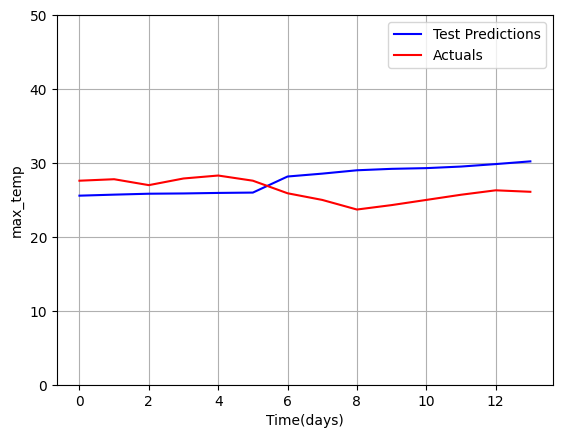

In [ ]:
# Plot the data with labels
plt.plot(test_results['Test Predictions'] ,label='Test Predictions', color='blue')
plt.plot(test_results['Actuals'], label='Actuals', color='red')

# Add labels for the x-axis and y-axis
plt.xlabel('Time(days)')
plt.ylabel('max_temp')

# Add a legend to distinguish the two lines
plt.legend()

# Set the y-axis limits to reduce the scale (adjust the values as needed)
plt.ylim(0, 50)

# Show the plot
plt.grid(True)
plt.show()